In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

In [19]:
dataset = read_csv("household_power_consumption.csv",
                   sep=';',
                   parse_dates={'dt' : ['Date', 'Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [20]:
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [21]:
values

array([[  4.216,   0.418, 234.84 , ...,   0.   ,   1.   ,  17.   ],
       [  5.36 ,   0.436, 233.63 , ...,   0.   ,   1.   ,  16.   ],
       [  5.374,   0.498, 233.29 , ...,   0.   ,   2.   ,  17.   ],
       ...,
       [  0.938,   0.   , 239.82 , ...,   0.   ,   0.   ,   0.   ],
       [  0.934,   0.   , 239.7  , ...,   0.   ,   0.   ,   0.   ],
       [  0.932,   0.   , 239.55 , ...,   0.   ,   0.   ,   0.   ]],
      dtype=float32)

In [22]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [23]:
scaled.head(4)

,0,1,2,3,4,5,6
0,0.379069,0.300719,0.924021,0.380165,0.0,0.0125,0.548387
1,0.481928,0.313669,0.919260,0.475207,0.0,0.0125,0.516129
2,0.483186,0.358273,0.917922,0.475207,0.0,0.0250,0.548387
3,0.484445,0.361151,0.919693,0.475207,0.0,0.0125,0.548387


In [24]:
lookback=1
predicted_col=1

In [25]:
temp=dataset.copy()

In [26]:
temp["id"]= range(1, len(temp)+1)

In [28]:
temp.head(4)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,id
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,3
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,4


In [29]:
temp = temp.iloc[:-lookback, :]

In [30]:
temp.head(4)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,id
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,3
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,4


In [31]:
temp.set_index('id', inplace =True)

In [32]:
temp.head(4)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
id,,,,,,,
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0


In [33]:
predicted_value=dataset.copy()

In [34]:
predicted_value.head(4)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0


In [35]:
predicted_value = predicted_value.iloc[lookback:,predicted_col]

In [36]:
predicted_value.head(4)

dt
2006-12-16 17:25:00    0.436
2006-12-16 17:26:00    0.498
2006-12-16 17:27:00    0.502
2006-12-16 17:28:00    0.528
Name: Global_reactive_power, dtype: float64

In [39]:
predicted_value.columns=["Predcited"]

In [40]:
predicted_value.head(4)

dt
2006-12-16 17:25:00    0.436
2006-12-16 17:26:00    0.498
2006-12-16 17:27:00    0.502
2006-12-16 17:28:00    0.528
Name: Global_reactive_power, dtype: float64

In [41]:
predicted_value= pd.DataFrame(predicted_value)

In [42]:
predicted_value.head(4)

,Global_reactive_power
dt,
2006-12-16 17:25:00,0.436
2006-12-16 17:26:00,0.498
2006-12-16 17:27:00,0.502
2006-12-16 17:28:00,0.528


In [43]:
predicted_value["id"]= range(1, len(predicted_value)+1)

In [44]:
predicted_value.head(4)

,Global_reactive_power,id
dt,,
2006-12-16 17:25:00,0.436,1
2006-12-16 17:26:00,0.498,2
2006-12-16 17:27:00,0.502,3
2006-12-16 17:28:00,0.528,4


In [45]:
predicted_value.set_index('id', inplace =True)

In [46]:
predicted_value.head(4)

,Global_reactive_power
id,
1,0.436
2,0.498
3,0.502
4,0.528


In [47]:
final_df= pd.concat([temp, predicted_value], axis=1)

In [48]:
final_df.head(4)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_reactive_power
id,,,,,,,,
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,0.436
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,0.498
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,0.502
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,0.528


In [49]:
def create_ts_data(dataset, lookback=1, predicted_col=1):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [50]:
reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)','var1(t)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    0.379069   0.300719   0.924021   0.380165        0.0     0.0125   
2    0.481928   0.313669   0.919260   0.475207        0.0     0.0125   
3    0.483186   0.358273   0.917922   0.475207        0.0     0.0250   
4    0.484445   0.361151   0.919693   0.475207        0.0     0.0125   

    var7(t-1)   var1(t)  
id                       
1    0.548387  0.481928  
2    0.516129  0.483186  
3    0.548387  0.484445  
4    0.548387  0.329617  


In [51]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [52]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1452681, 1, 7) (1452681,) (622577, 1, 7) (622577,)


In [53]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')

In [54]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 75)             24900     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             12720     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 44,971
Trainable params: 44,971
Non-trainable params: 0
_________________________________________________________________


In [55]:
# fit network
history_lstm = model_lstm.fit(train_X, train_y, epochs=10, 
              batch_size=64, validation_data=(test_X, test_y),  shuffle=False)

Epoch 1/10
22699/22699 [==============================] - 169s 7ms/step - loss: 0.0113 - val_loss: 0.0087
Epoch 2/10
22699/22699 [==============================] - 206s 9ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 3/10
22699/22699 [==============================] - 212s 9ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 4/10
22699/22699 [==============================] - 161s 7ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 5/10
22699/22699 [==============================] - 178s 8ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 6/10
22699/22699 [==============================] - 236s 10ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 7/10
22699/22699 [==============================] - 159s 7ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 8/10
22699/22699 [==============================] - 176s 8ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 9/10
22699/22699 [==============================] - 245s 11ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 10/10
22699/22699 [===================

In [56]:
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')

In [57]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 75)             18900     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 30)             9630      
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 34,141
Trainable params: 34,141
Non-trainable params: 0
_________________________________________________________________


In [59]:
# fit network
gru_history = model_gru.fit(train_X, train_y, epochs=10, batch_size=64, 
                        validation_data=(test_X, test_y), shuffle=False)

Epoch 1/10
22699/22699 [==============================] - 268s 11ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 2/10
22699/22699 [==============================] - 200s 9ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 3/10
22699/22699 [==============================] - 203s 9ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 4/10
22699/22699 [==============================] - 303s 13ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 5/10
22699/22699 [==============================] - 192s 8ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 6/10
22699/22699 [==============================] - 233s 10ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 7/10
22699/22699 [==============================] - 244s 11ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 8/10
22699/22699 [==============================] - 273s 12ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 9/10
22699/22699 [==============================] - 196s 9ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 10/10
22699/22699 [================

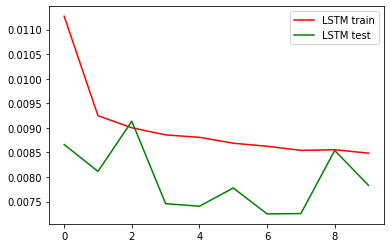

In [62]:
pyplot.plot(history_lstm.history['loss'], label='LSTM train', color='red')
pyplot.plot(history_lstm.history['val_loss'], label='LSTM test', color= 'green')
pyplot.legend()
pyplot.show()

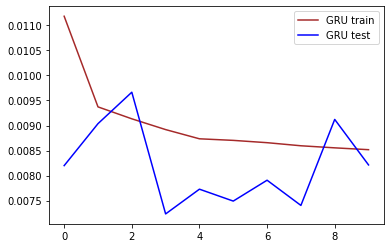

In [63]:
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
pyplot.legend()
pyplot.show()